In [9]:
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq

input="input.vib"

commd1 = []
commd2 = []
with open(input, "r") as file:
    after_first_flag = False  # Track if we're after the first '\'

    # Iterate over the file line by line
    for command in file:
        command = command.strip()  # Remove extra spaces or newlines       
        # Check if the current line is the flag '\'
        if command == "\\":
            after_first_flag = True  # Switch to storing in commd2 after first '\'
            continue  # Skip the flag line itself       
        # Store the commands based on the flag location
        if after_first_flag:
            commd2.append(command)
        else:
            commd1.append(command)

for cmd in commd1:            #load files and input parameters from input.vib
    exec(cmd)    
# Load your trajectory and topology files
u = mda.Universe(pdb_file, traj_file)

# Print the unique segids and residue names to identify sugars
unique_segids = set(atom.segid for atom in u.atoms)
unique_residues = set(atom.resname for atom in u.atoms)
print("Unique SegIDs:", unique_segids)
print("Unique Residues:", unique_residues)


for cmd in commd2:         #load selected atoms or units from input.vib
    exec(cmd)


# Command line examples:
#selection1 = u.select_atoms("segid CARA and resnum 1 and name O6")
#selection1 = u.select_atoms("segid CARB and resnum 1")
#selection1 = u.select_atoms("segid PROA and resname ASP and resid 239")
#selection1 = u.select_atoms("segid PROA")
#
#selection2 = u.select_atoms("segid CARC and resnum 4 and name HO6")
#selection2 = u.select_atoms("segid CARC and resnum 4")
#selection2 = u.select_atoms("segid PROC and resname LYS and resid 138")
#selection2 = u.select_atoms("segid PROC")


Unique SegIDs: {'PROB', 'PROC', 'CARA', 'CARB', 'CARD', 'CARC', 'PROA'}
Unique Residues: {'ALA', 'MET', 'GLN', 'GLU', 'LYS', 'LEU', 'BGLC', 'AFUC', 'AMAN', 'ARG', 'BMAN', 'TRP', 'ASN', 'PHE', 'GLY', 'BGAL', 'SER', 'HIS', 'THR', 'TYR', 'PRO', 'VAL', 'ILE', 'ASP', 'CYS'}


Distance between centers of mass running ..... 
done
Average over all traj. : 51.6407575448305
Distances between centers of mass saved in distance.dat
Autocorrelation function & FFT running ...
done


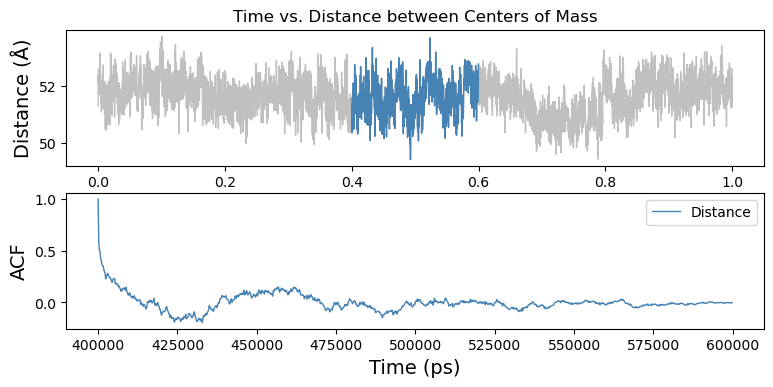

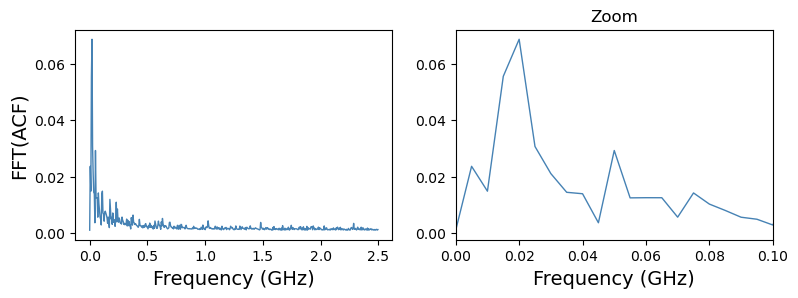

In [10]:
print('Distance between centers of mass running ..... ')

# Calculate the center of mass for each frame  (or type 'compound='residues')
com_selection1 = np.array([selection1.center_of_mass(compound='group') for ts in u.trajectory])
com_selection2 = np.array([selection2.center_of_mass(compound='group') for ts in u.trajectory])

#print(np.shape(com_selection1))

# Reshape the arrays for the distance calculation
com_selection1_reshaped = com_selection1.reshape((len(com_selection1), 3))
com_selection2_reshaped = com_selection2.reshape((len(com_selection2), 3))


# Calculate distances between centers of mass for each frame
distances_array = mda.lib.distances.distance_array(com_selection1_reshaped, com_selection2_reshaped, \
                                                   box=u.dimensions)

# Calculate the distance between the two selected elements
distances=np.diag(distances_array)
print("done")
# Print the average distances
average_distances = np.mean(distances_array, axis=1)
print("Average over all traj. :",np.mean(average_distances))
print("Distances between centers of mass saved in \033[1mdistance.dat\033[0m")
time_values = [ts.time for ts in u.trajectory]
np.savetxt('data/distance.dat', distances)

#################" ACF Calculation
print('Autocorrelation function & FFT running ...')

# distance.dat obtained above
fname='data/distance.dat'   
dat=np.loadtxt(fname, delimiter=' ', dtype = float)
yraw_all=dat[0:len(dat)]
#check trajectory parameters defined (or not) in input.vib
if not 'traj_min' in locals():
    traj_min=0
if not 'traj_max' in locals():
    traj_max=len(dat)
if not 'dt' in locals():
    print("\033[1mWARNING\033[0m : timestep 'dt' not defined, set to default (0.2ns)")
    dt=0.2 # timestep in ns

yraw=dat[traj_min:traj_max]
N=len(yraw)
time=[ts.time for ts in u.trajectory]
time_all=time[:]
time=time[traj_min:traj_max]

    
# Calculate ACF
yac = sm.tsa.acf(yraw, nlags=2*N-1)
xacf=fftfreq(N,dt)[:N//2]          #freqmax=(1/dt)/2 : dt= en ns => freq en GHZ
yacf=fft(yac)

print("done")

# Create a figure for all XY plots
plt.figure(figsize=(9, 6))

label="Distance"
plt.subplot(3,1,1)
plt.plot(time_all,yraw_all,marker='',linestyle='-', label=label, linewidth=1,color='silver')
plt.plot(time, yraw, marker='', linestyle='-', label=label, linewidth=1,color='steelblue')
plt.title("Time vs. Distance between Centers of Mass")
plt.ylabel("Distance (Å)", fontsize=14)
plt.subplot(3,1,2)
plt.plot(time, yac, marker='', linestyle='-', label=label,  linewidth=1,color='steelblue')
plt.ylabel("ACF", fontsize=14)
plt.xlabel("Time (ps)", fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.subplot(2,2,2)
plt.plot(xacf,2.0/N * np.abs(yacf[0:N//2]), marker='', linestyle='-', label=label, linewidth=1,color='steelblue')
plt.xlabel("Frequency (GHz)", fontsize=14)
plt.xlim(0,0.1)
plt.title("Zoom")
plt.subplot(2,2,1)
plt.plot(xacf,2.0/N * np.abs(yacf[0:N//2]), marker='', linestyle='-', label=label, linewidth=1,color='steelblue')
plt.xlabel("Frequency (GHz)", fontsize=14)
plt.ylabel("FFT(ACF)", fontsize=14)
plt.show()    
    
#save data
#ac = np.column_stack((xac*dt, yac))       #Autocorrelation function
#acf= np.column_stack((xac*dt, yacf))     # FFT(ACF)

